In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

np.random.seed(114514)

In [12]:
def generate_gmm_samples(mus, cov, weights, N):
    n_clusters = len(weights)
    samples_per_cluster = N // n_clusters
    samples = []
    for i in range(n_clusters):
        cluster_samples = multivariate_normal.rvs(mean=mus[i], cov=cov, size=samples_per_cluster)
        samples.append(cluster_samples)
    samples = np.vstack(samples)
    np.random.shuffle(samples)
    return samples

def plot_gmm_contour(ax, samples, mus, cov, weights, title, color='blue'):
    x, y = np.mgrid[-7:7:.01, -7:7:.01]
    pos = np.dstack((x, y))
    gmm_pdf = sum(w * multivariate_normal.pdf(pos, mean=mu, cov=cov) for w, mu in zip(weights, mus))
    
    ax.contour(x, y, gmm_pdf, levels=10, cmap='viridis', alpha=0.3)
    ax.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5, c=color)
    ax.set_title(title)
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")
    ax.grid(True)
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)

mus = np.array([
    [0, 1], [1, 0], [0, -1], [-1, 0],
]) * 4

cov = np.eye(2)/2
weights = np.ones(4)/4
N = 10000

samples = generate_gmm_samples(mus, cov, weights, N)

In [13]:
def fit_gmm(samples, n_components=2):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(samples)
    return gmm

fitted_gmm = fit_gmm(samples, n_components=4)
mus = fitted_gmm.means_
weights = fitted_gmm.weights_
covs = fitted_gmm.covariances_
print(mus)
print(weights)
print(covs)

[[-3.98975740e+00 -2.09003288e-02]
 [ 4.00409314e+00 -8.70750893e-04]
 [-1.59746155e-02 -3.99647913e+00]
 [ 2.34950634e-02  4.01517293e+00]]
[0.25012411 0.25009621 0.24978375 0.24999593]
[[[0.50296698 0.00870843]
  [0.00870843 0.51892442]]

 [[0.49764981 0.01196473]
  [0.01196473 0.4728579 ]]

 [[0.52700472 0.01625011]
  [0.01625011 0.50439296]]

 [[0.51053773 0.01668588]
  [0.01668588 0.50394063]]]


In [14]:
def forward_diffusion(initial_samples, drift_func, diffusion_func, T=10, n_steps=500, save_every=10):
    dt = T / n_steps
    samples = initial_samples.copy()
    trajectory = [samples.copy()]
    
    for i in range(n_steps):
        t = i * dt
        drift = drift_func(samples, t)
        diffusion = diffusion_func(samples, t)
        noise = np.random.randn(*samples.shape) * np.sqrt(dt)
        samples += drift * dt + diffusion * noise
        
        if i % save_every == 0:
            trajectory.append(samples.copy())
    
    return trajectory

In [15]:
def reverse_diffusion(initial_noise, drift_func, diffusion_func, score_func, T=10, n_steps=500, save_every=10):
    dt = T / n_steps
    samples = initial_noise.copy()
    trajectory = [samples.copy()]
    
    for i in range(n_steps):
        t = T - i * dt
        drift = drift_func(samples, t)
        diffusion = diffusion_func(samples, t)
        score = score_func(samples, t)
        noise = np.random.randn(*samples.shape) * np.sqrt(dt)
        
        # 反向SDE
        rev_drift = drift - diffusion**2 * score
        samples += - rev_drift * dt + diffusion * noise
        
        if i % save_every == 0:
            trajectory.append(samples.copy())
    
    return trajectory

In [16]:
def simple_drift(x, t):
    return np.zeros_like(x)

def simple_diffusion(x, t):
    return np.ones_like(x)

def gmm_score(x, t, fitted_gmm):
    mus = fitted_gmm.means_
    weights = fitted_gmm.weights_
    covs = fitted_gmm.covariances_
    K, D = mus.shape
    N = x.shape[0]

    # 修正协方差矩阵的处理方式
    if fitted_gmm.covariance_type == 'diag':
        # 将对角协方差转换为完整矩阵
        cov_t = np.array([np.diag(cov) + np.eye(D) * t for cov in covs])
    else:
        # 如果是full或tied类型
        cov_t = covs + np.eye(D) * t
    
    log_probs = np.zeros((N, K))
    for k in range(K):
        diff = x - mus[k]
        inv_cov = np.linalg.inv(cov_t[k])
        log_probs[:,k] = -0.5 * np.einsum('ni,ij,nj->n', diff, inv_cov, diff) \
                        - 0.5 * np.log(np.linalg.det(2 * np.pi * cov_t[k])) \
                        + np.log(weights[k])

    max_log = np.max(log_probs, axis=1, keepdims=True)
    log_norm = max_log + np.log(np.sum(np.exp(log_probs - max_log), axis=1, keepdims=True))
    log_resp = log_probs - log_norm

    score = np.zeros((N, D))
    for k in range(K):
        inv_cov = np.linalg.inv(cov_t[k])
        diff = x - mus[k]
        score += -np.exp(log_resp[:,k,None]) * (diff @ inv_cov)

    return score

In [17]:
T = 10  # 统一时间范围
n_steps = 10000  # 适当减少步数以平衡精度和效率

trajectory_forward = forward_diffusion(
    samples, simple_drift, simple_diffusion, T=T, n_steps=n_steps
)

trajectory_reverse = reverse_diffusion(
    trajectory_forward[-1], simple_drift, simple_diffusion,
    lambda x, t: gmm_score(x, t, fitted_gmm), T=T, n_steps=n_steps
)

final_samples = trajectory_reverse[-1]

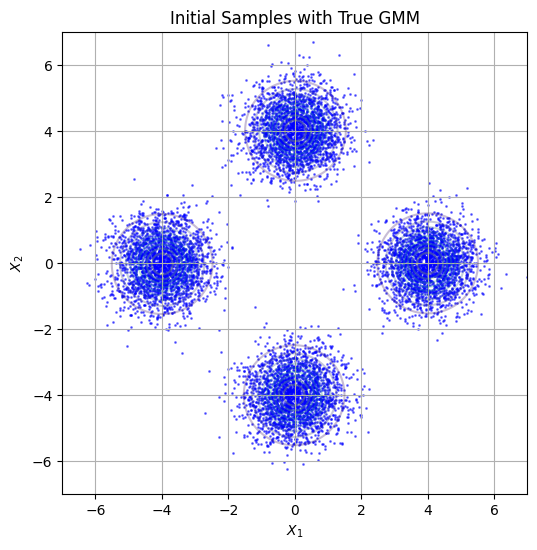

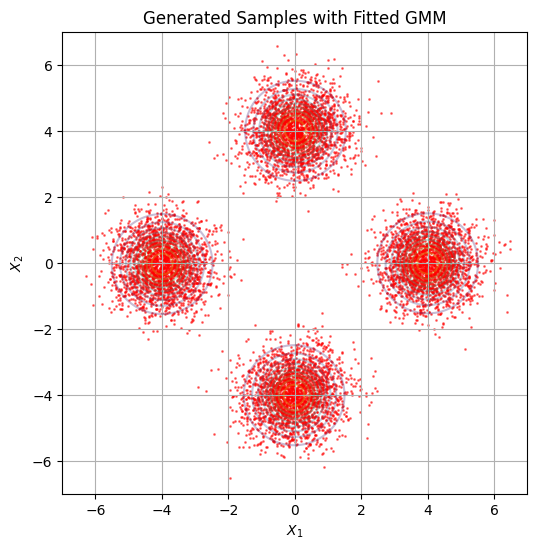

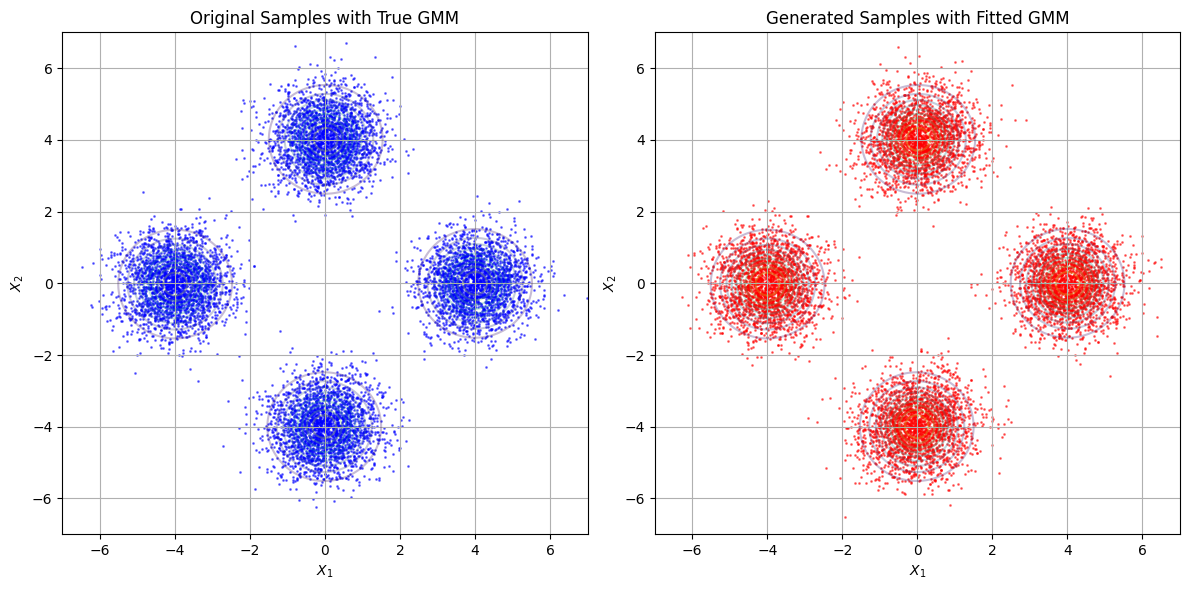

In [21]:
def plot_comparison(original, generated, mus, cov, weights, filename=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # 原始样本子图
    plot_gmm_contour(ax1, original, mus, cov, weights, "Original Samples with True GMM", color='blue')
    
    # 生成样本子图
    plot_gmm_contour(ax2, generated, mus, cov, weights, "Generated Samples with Fitted GMM", color='red')
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_single_gmm(samples, mus, cov, weights, title, color='blue', filename=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_gmm_contour(ax, samples, mus, cov, weights, title, color=color)
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
# 绘制对比图
plot_single_gmm(samples, mus, cov, weights, "Initial Samples with True GMM", 
                color='blue', filename='figures/gmm_true_samples.png')

plot_single_gmm(trajectory_reverse[-1], mus, cov, weights, "Generated Samples with Fitted GMM", 
                color='red', filename='figures/gmm_generated_samples.png')


plot_comparison(samples, trajectory_reverse[-1], mus, cov, weights, filename='figures/sample_comparison.png')


In [24]:
len(trajectory_forward)

1001

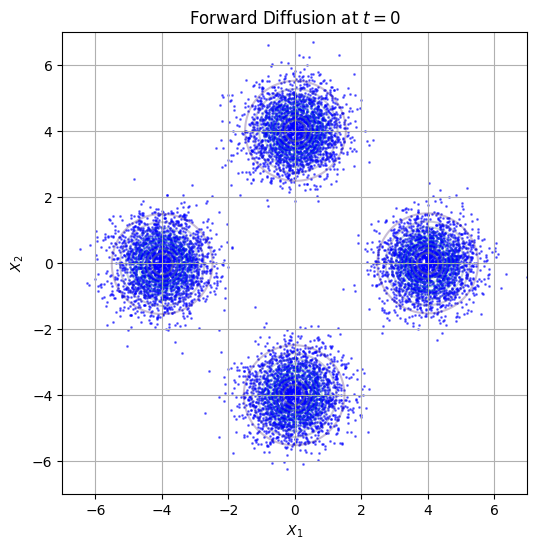

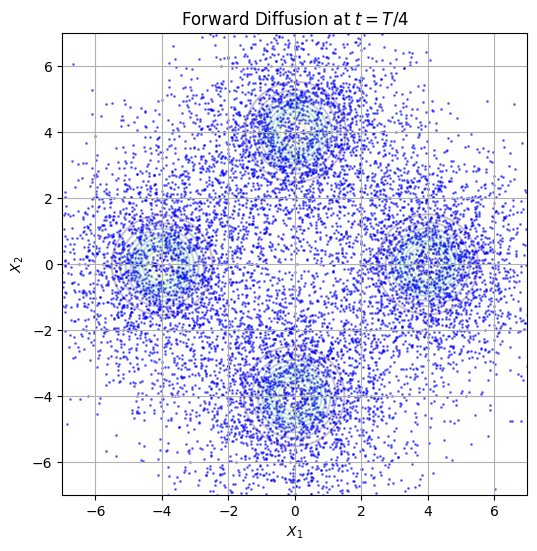

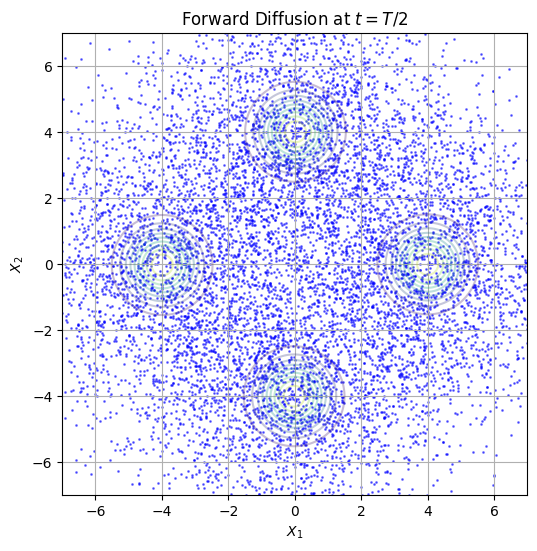

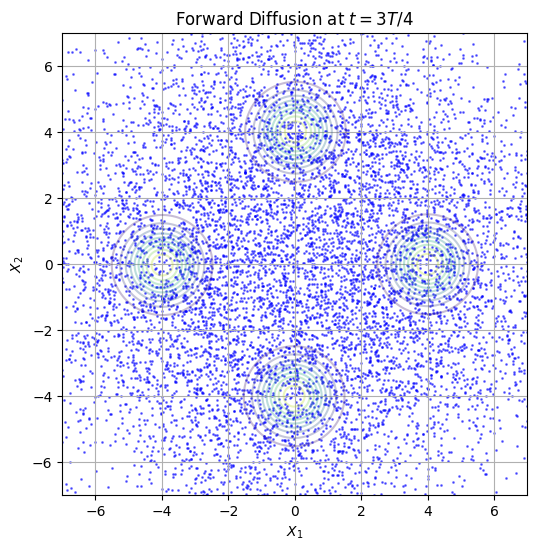

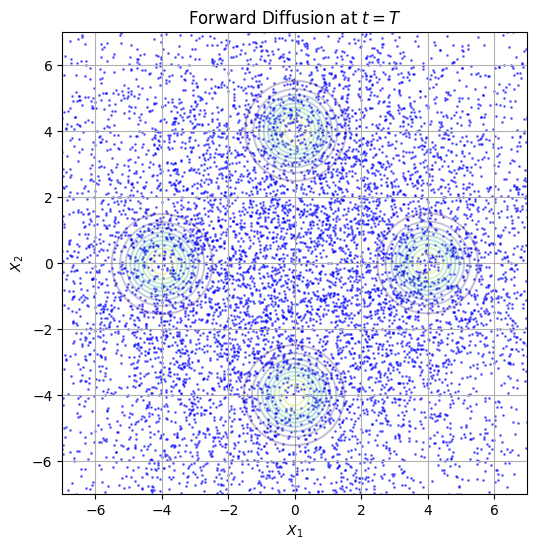

In [25]:
n = len(trajectory_forward)
t0_samples = trajectory_forward[0]
t025_samples = trajectory_forward[n//4]
t5_samples = trajectory_forward[n//2]
t075_samples = trajectory_forward[3*n//4]
t10_samples = trajectory_forward[-1]

# 绘制并保存 5 张图
plot_single_gmm(t0_samples, mus, cov, weights, "Forward Diffusion at $t=0$", 
                color='blue', filename='figures/forward_diffusion_t0.png')
plot_single_gmm(t025_samples, mus, cov, weights, "Forward Diffusion at $t=T/4$", 
                color='blue', filename='figures/forward_diffusion_t025.png')
plot_single_gmm(t5_samples, mus, cov, weights, "Forward Diffusion at $t=T/2$", 
                color='blue', filename='figures/forward_diffusion_t5.png')
plot_single_gmm(t075_samples, mus, cov, weights, "Forward Diffusion at $t=3T/4$", 
                color='blue', filename='figures/forward_diffusion_t075.png')
plot_single_gmm(t10_samples, mus, cov, weights, "Forward Diffusion at $t=T$", 
                color='blue', filename='figures/forward_diffusion_t10.png')

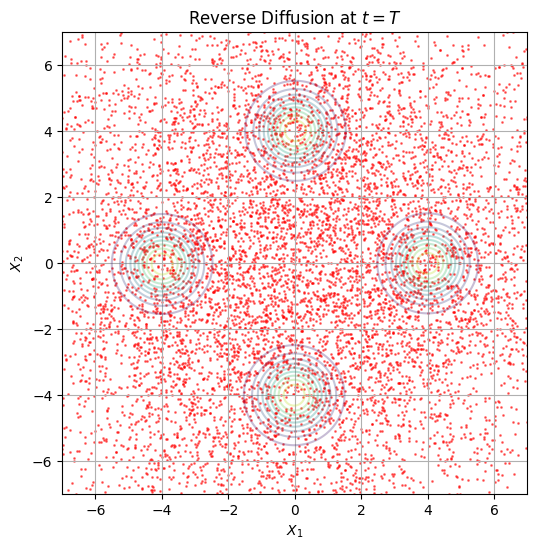

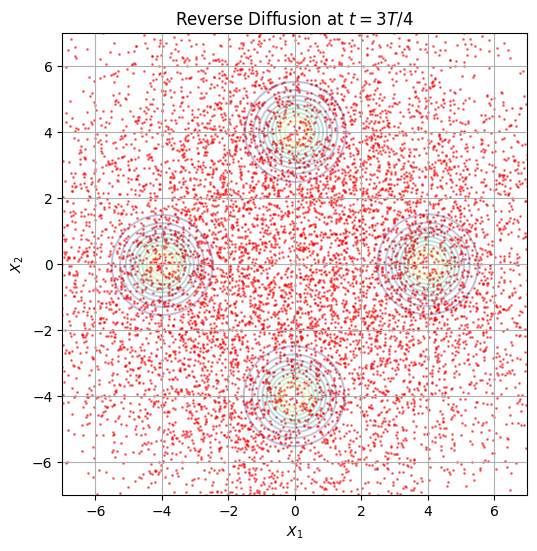

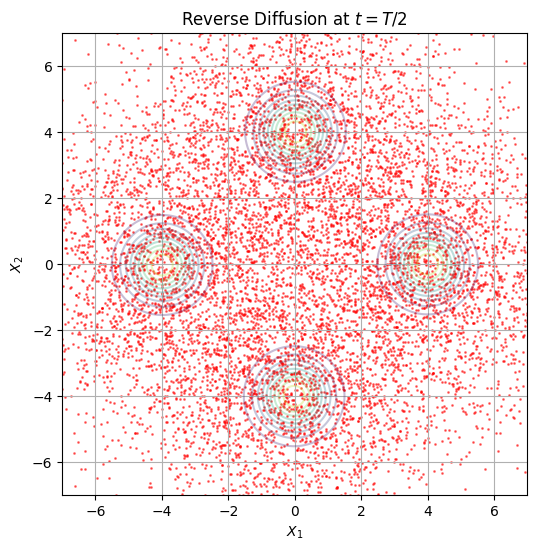

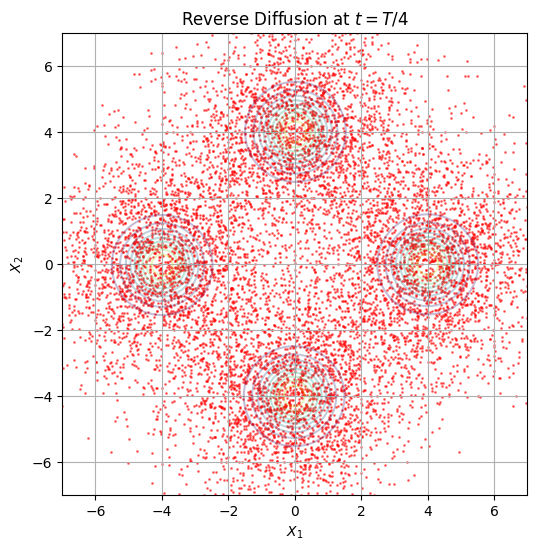

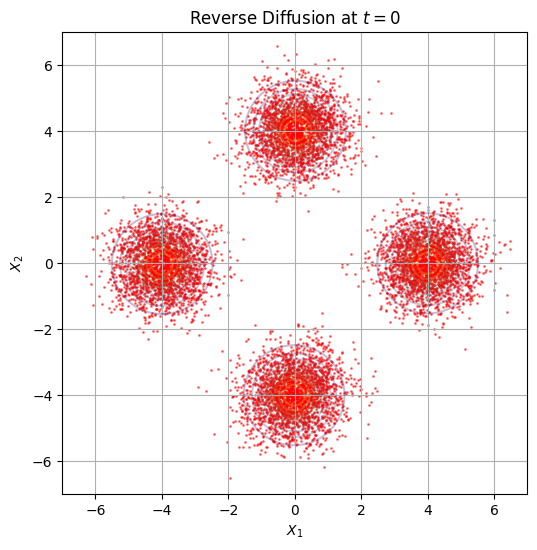

In [26]:
n = len(trajectory_reverse)

t10_samples = trajectory_reverse[0]     # t = 1 (起点)
t075_samples = trajectory_reverse[n//4]  # t = 0.75
t5_samples = trajectory_reverse[n//2]   # t = 0.5
t025_samples = trajectory_reverse[3*n//4] # t = 0.25
t0_samples = trajectory_reverse[-1]   # t = 0 (终点)

# 绘制并保存反向扩散图
plot_single_gmm(t10_samples, mus, cov, weights, "Reverse Diffusion at $t=T$", 
                color='red', filename='figures/reverse_diffusion_t10.png')
plot_single_gmm(t075_samples, mus, cov, weights, "Reverse Diffusion at $t=3T/4$", 
                color='red', filename='figures/reverse_diffusion_t075.png')
plot_single_gmm(t5_samples, mus, cov, weights, "Reverse Diffusion at $t=T/2$", 
                color='red', filename='figures/reverse_diffusion_t5.png')
plot_single_gmm(t025_samples, mus, cov, weights, "Reverse Diffusion at $t=T/4$", 
                color='red', filename='figures/reverse_diffusion_t025.png')
plot_single_gmm(t0_samples, mus, cov, weights, "Reverse Diffusion at $t=0$", 
                color='red', filename='figures/reverse_diffusion_t0.png')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def binary_classification_test(original, generated):
    # 创建标签数据集
    X = np.vstack([original, generated])
    y = np.array([0]*len(original) + [1]*len(generated))
    
    # 训练分类器
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf = RandomForestClassifier(n_estimators=50)
    clf.fit(X_train, y_train)
    
    # 输出准确率
    acc = clf.score(X_test, y_test)
    print(f"分类准确率: {acc:.3f} (越接近0.5越好)")

# 调用示例
binary_classification_test(samples, trajectory_reverse[-1])

分类准确率: 0.512 (越接近0.5越好)


In [ ]:
def animate_diffusion(trajectory_forward, trajectory_reverse, mus, cov, weights, filename='figures/diffusion_process.gif'):
    # 参数设置
    skip = 5  # 下采样因子
    pause_frames = 10  # 在起点和终点停留的帧数
    interval = 100  # 每帧间隔时间(ms)
    
    # 下采样轨迹
    traj_fwd = trajectory_forward[::skip]
    traj_rev = trajectory_reverse[::skip]  # 反向轨迹需要时间倒序
    
    # 创建带有停留点的帧序列
    def create_sequence(trajectory, is_reverse=False):
        sequence = []
        # 起点停留
        sequence.extend([trajectory[0]] * pause_frames)
        # 主体部分
        sequence.extend(trajectory)
        # 终点停留
        sequence.extend([trajectory[-1]] * pause_frames)
        return sequence
    
    # 创建完整轨迹序列
    full_trajectory = create_sequence(traj_fwd) + create_sequence(traj_rev)
    n_frames = len(full_trajectory)
    
    # 计算真实 GMM 的等高线
    x, y = np.mgrid[-7:7:.01, -7:7:.01]
    pos = np.dstack((x, y))
    gmm_pdf = sum(w * multivariate_normal.pdf(pos, mean=mu, cov=cov) for w, mu in zip(weights, mus))
    
    # 设置画布
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.contour(x, y, gmm_pdf, levels=10, cmap='viridis', alpha=0.3)
    scatter = ax.scatter([], [], s=1, alpha=0.5, c='red', label='Samples')
    ax.set_title('Diffusion Process')
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    
    # 初始化函数
    def init():
        scatter.set_offsets(np.empty((0, 2)))
        return scatter,
    
    # 更新函数
    def update(frame):
        samples = full_trajectory[frame]
        scatter.set_offsets(samples)
        
        # 计算当前阶段
        fwd_len = len(create_sequence(traj_fwd))
        
        if frame < fwd_len:
            # 正向扩散阶段
            if frame < pause_frames:
                ax.set_title('Forward Diffusion Starting (t=0.0)')
            elif frame >= fwd_len - pause_frames:
                ax.set_title('Forward Diffusion Completed (t=10.0)')
            else:
                t = (frame - pause_frames) / (len(traj_fwd)-1) * 10
                ax.set_title(f'Forward Diffusion at $t={t:.1f}$')
        else:
            # 反向扩散阶段
            rev_frame = frame - fwd_len
            if rev_frame < pause_frames:
                ax.set_title('Reverse Diffusion Starting (t=10.0)')
            elif rev_frame >= len(create_sequence(traj_rev)) - pause_frames:
                ax.set_title('Reverse Diffusion Completed (t=0.0)')
            else:
                t = 10 - (rev_frame - pause_frames) / (len(traj_rev)-1) * 10
                ax.set_title(f'Reverse Diffusion at $t={t:.1f}$')
        
        return scatter,
    
    # 创建动画
    anim = FuncAnimation(fig, update, init_func=init, frames=n_frames, interval=interval, blit=True)
    
    # 保存动画
    try:
        anim.save(filename, writer='ffmpeg', fps=2000/interval, dpi=200)
    except:
        anim.save(filename, writer='pillow', fps=000/interval, dpi=200)
    
    plt.close()

# 使用正向和反向轨迹生成动画
animate_diffusion(trajectory_forward, trajectory_reverse, mus, cov, weights)

MovieWriter ffmpeg unavailable; using Pillow instead.
